# Word Mover’s Distance

In [1231]:
import gensim.parsing.preprocessing as genproc

from gensim.utils import deaccent
from gensim.models import KeyedVectors
from gensim.models.normmodel import NormModel
from gensim import corpora

import numpy as np
import pandas as pd

import time
import timeit

## Sentences

In [1249]:
f_strs = open("data/test_sentences.txt", "r", encoding='utf-8')
strs = [str for str in f_strs.readlines()]
strs

['Obama speaks to the media in Illinois\n',
 'The President greets the press in Chicago.\n',
 'Orange Prize winner Andrea Levy has seen her book Small Island win the Whitbread Novel of the Year Award.\n',
 "Sonia President has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne.\n",
 "The President's firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n",
 'Denmark is holding a three-day celebration of the life of the fairy-tale author, with a concert at Parken stadium on 2 April. Other stars are expected to join the line-up in the coming months, and the Danish royal family will attend. "Christian Andersen\'s fairy tales are timeless and universal," said Jarre. "For all

In [1250]:
f_strs = open("data/bbc/business/001.txt")
strs_bbc = [str for str in f_strs.readlines()]
strs_bbc

['Ad sales boost Time Warner profit\n',
 'Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn for the three months to December, from $639m year-earlier.\n',
 'The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n',
 "Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

## Preprocessing

### Stopwords removal

In [1251]:
proc = [genproc.remove_stopwords, 
    genproc.strip_tags,
    genproc.strip_punctuation,
    genproc.strip_multiple_whitespaces,
    genproc.strip_numeric,
    genproc.remove_stopwords,
    genproc.strip_short,
    deaccent]
    #genproc.stem_text]

def apply_lambdas(x, lambdas):
    return [p(x) for p in lambdas][-1]

In [1252]:
strs_proc = [genproc.preprocess_string(str, proc) for str in strs]
strs_bbc_proc = [genproc.preprocess_string(str, proc) for str in strs_bbc]

## nBOW

In [1254]:
dict = corpora.Dictionary()
bows = [dict.doc2bow(str, allow_update=True) for str in strs_proc]
print(dict.num_pos)

726


In [1255]:
dict_bbc = corpora.Dictionary()
bows_bbc = [dict.doc2bow(str, allow_update=True) for str in strs_bbc_proc]
print(dict_bbc.num_pos)

0


In [1256]:
def get_from_tuples(tuples, i, bows=bows):
    l = [[t[1]] * b[1] for (b, t) in zip(bows[i], tuples)]
    return [x for sub in l for x in sub]

In [1257]:
norm_model = NormModel(norm='l1')
nbows_simple = [get_from_tuples(norm_model.normalize(bows[i]), i) for i in range(len(strs_proc))]

In [1258]:
nbows_bbc = [get_from_tuples(norm_model.normalize(bows_bbc[i]), i, bows_bbc) for i in range(len(strs_bbc_proc))]

## word2vec

In [175]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [942]:
model.init_sims(replace=True)

### Set current dataset

In [1259]:
#nbows = nbows_bbc
nbows = nbows_simple
strs_proc_simple = strs_proc
#strs_proc = strs_bbc_proc
strs_proc = strs_proc_simple

### Distances cache

In [1260]:
class bidir_dict():
    def __init__(self):
        self.dict = {}
    def __len__(self):
        return self.dict.__len__(self) / 2

    def __setitem__(self, key, value):
        self.dict.__setitem__(key, value)
        
    def __getitem__(self, key):
        g = self.dict.get(key)
        if g == None:
            g = self.dict.get((key[1], key[0]))
        return g

dists = bidir_dict()

## WCD

### $WCD(d, d') = \left\lVert Xd - Xd' \right\rVert_2$

In [1261]:
def get_centroid(doc):
    X = np.array([model[str] for str in strs_proc[doc]])
    d = np.array(nbows[doc])
    
    return X.T.dot(d)

In [1262]:
def dist(x, y, i, j):
    return np.sqrt(np.sum((x - y)**2))

In [1263]:
def dist(x, y, i, j):
    d = dists[(i, j)]
    if d == None:
        d = np.sqrt(np.sum((x - y)**2))
        dists[(i, j)] = d
    return d

In [1264]:
def wcd(doc1, doc2):
    c1 = get_centroid(doc1)
    c2 = get_centroid(doc2)
    return dist(c1, c2, doc1, doc2)

In [1265]:
[wcd(0, i) for i in range(len(nbows))]

[0.0,
 0.4889688754349564,
 0.6282021317744428,
 0.607863411337698,
 0.6216390672798184,
 0.5685506211966792,
 0.634117029062517,
 0.6086501006435308,
 2.294856610359048,
 0.8530214259104537,
 0.8912037390990674,
 0.8495958119706942,
 0.740203290171906,
 0.6066595381454836,
 0.765175278237766,
 0.6506489116202538,
 0.6153644479910629,
 0.7279378379077874,
 0.6405168303900033,
 0.6178455141858197,
 0.5810393113521084,
 0.679971016715287]

In [1266]:
strs_proc

[['Obama', 'speaks', 'media', 'Illinois'],
 ['The', 'President', 'greets', 'press', 'Chicago'],
 ['Orange',
  'Prize',
  'winner',
  'Andrea',
  'Levy',
  'seen',
  'book',
  'Small',
  'Island',
  'win',
  'Whitbread',
  'Novel',
  'Year',
  'Award'],
 ['Sonia',
  'President',
  'indicated',
  'like',
  'participate',
  'month',
  'World',
  'Cross',
  'Country',
  'Championships',
  'Etienne'],
 ['The',
  'President',
  'firm',
  'biggest',
  'investors',
  'Google',
  'benefited',
  'sales',
  'high',
  'speed',
  'internet',
  'connections',
  'higher',
  'advert',
  'sales',
  'TimeWarner',
  'said',
  'fourth',
  'quarter',
  'sales',
  'rose',
  'Its',
  'profits',
  'buoyed',
  'gains',
  'offset',
  'profit',
  'dip',
  'Warner',
  'Bros',
  'users',
  'AOL'],
 ['Denmark',
  'holding',
  'day',
  'celebration',
  'life',
  'fairy',
  'tale',
  'author',
  'concert',
  'Parken',
  'stadium',
  'April',
  'Other',
  'stars',
  'expected',
  'join',
  'line',
  'coming',
  'month

## Relaxed WMD

In [1267]:
def rwmd_implem_1(doc1, doc2):
    X = model
    idx = 0
    rwmd1 = 0
    for j in strs_proc[doc1]:
        c_ij = [dist(X[j], X[i], i, j) for i in strs_proc[doc2]]
        rwmd1 += min(c_ij) * nbows[doc1][idx]
        idx += 1
    idx = 0
    rwmd2 = 0
    for j in strs_proc[doc2]:
        c_ij = [dist(X[j], X[i], i, j) for i in strs_proc[doc1]]
        rwmd2 += min(c_ij) * nbows[doc2][idx]
        idx += 1
        
    return max(rwmd1, rwmd2)

def rwmd_implem_2(doc1, doc2):
    doc1_len = len(nbows[doc1])
    doc2_len = len(nbows[doc2])
    doc1_dists = np.ones(doc1_len) * float('inf')
    doc2_dists = np.ones(doc2_len) * float('inf')
    
    dists = np.array([[dist(model[i], model[j], i, j) for j in strs_proc[doc2]] for i in strs_proc[doc1]])
    
    for word1_index in range(doc1_len):
        word1 = strs_proc[doc1][word1_index]
        for word2_index in range(doc2_len):
            word2 = strs_proc[doc2][word2_index]
            wdist = dists[word1_index][word2_index] 
            
            if wdist < doc1_dists[word1_index]:
                doc1_dists[word1_index] = wdist
            if wdist < doc2_dists[word2_index]:
                doc2_dists[word2_index] = wdist
    
    rwmd1 = np.sum(doc1_dists * nbows[doc1])
    rwmd2 = np.sum(doc2_dists * nbows[doc2])
    rwmd = max(rwmd1, rwmd2)
    return rwmd

def rwmd(doc1, doc2):
    doc1_len = len(nbows[doc1])
    doc2_len = len(nbows[doc2])
    
    dists = np.array([[dist(model[i], model[j], i, j) for j in strs_proc[doc2]] for i in strs_proc[doc1]])
    
    c_ij = np.array([np.min([dists[i][j] for j in range(doc2_len)]) for i in range(doc1_len)])
    rwmd1 = np.dot(c_ij, nbows[doc1])
    c_ij = np.array([np.min([dists[j][i] for j in range(doc1_len)]) for i in range(doc2_len)])
    rwmd2 = np.dot(c_ij, nbows[doc2])
    
    return max(rwmd1, rwmd2)

In [1268]:
#%timeit rwmd(6, 7)

In [1269]:
#%timeit rwmd_implem_1(9, 10)

In [1270]:
#%timeit rwmd_implem_2(9, 10)

In [1271]:
#%timeit wcd(9, 10)

In [1272]:
start = time.perf_counter()
wcd(0, 5)
end = time.perf_counter()
end - start

0.001515951007604599

In [1273]:
#%timeit model.wmdistance(strs_proc[6], strs_proc[7])

In [1274]:
start = time.perf_counter()
model.wmdistance(strs_proc[0], strs_proc[5])
end = time.perf_counter()
end - start

0.011177629989106208

In [1275]:
[rwmd_implem_1(0, j) for j in range(len(nbows))]

[0.0,
 1.0618066430091857,
 1.3466628619602747,
 1.3384341543371028,
 1.5745622590184212,
 1.6217780970945592,
 2.0408487006237634,
 2.1576749499963253,
 3.3718802332878113,
 1.3447080850601196,
 1.3566317558288574,
 1.3516850173473358,
 1.3274114429950714,
 1.3285035490989685,
 1.3340416848659515,
 1.336386799812317,
 1.7221189198955411,
 1.341009497642517,
 1.2823150591416792,
 1.7546531072882716,
 1.529034259142699,
 2.212308130985082]

In [1276]:
[rwmd_implem_2(0, j) for j in range(len(nbows))]

[0.0,
 1.0618066430091857,
 1.3466628619602747,
 1.3384341543371028,
 1.5745622590184212,
 1.621778097094559,
 2.040848700623763,
 2.1576749499963253,
 3.3718802332878113,
 1.3447080850601196,
 1.3566317558288574,
 1.3516850173473358,
 1.3274114429950714,
 1.3285035490989683,
 1.3340416848659515,
 1.336386799812317,
 1.7221189198955411,
 1.341009497642517,
 1.2823150591416792,
 1.7546531072882718,
 1.5290342591426989,
 2.2123081309850825]

In [1277]:
[rwmd(0, j) for j in range(len(nbows))]

[0.0,
 1.0618066430091857,
 1.3466628619602747,
 1.3384341543371028,
 1.5745622590184212,
 1.621778097094559,
 2.040848700623763,
 2.1576749499963253,
 3.3718802332878113,
 1.3447080850601196,
 1.3566317558288574,
 1.3516850173473358,
 1.3274114429950714,
 1.3285035490989685,
 1.3340416848659515,
 1.336386799812317,
 1.7221189198955411,
 1.341009497642517,
 1.2823150591416792,
 1.7546531072882718,
 1.5290342591426989,
 2.2123081309850825]

In [1278]:
[wcd(0, j) for j in range(len(nbows))]

[0.0,
 0.4889688754349564,
 0.6282021317744428,
 0.607863411337698,
 0.6216390672798184,
 0.5685506211966792,
 0.634117029062517,
 0.6086501006435308,
 2.294856610359048,
 0.8530214259104537,
 0.8912037390990674,
 0.8495958119706942,
 0.740203290171906,
 0.6066595381454836,
 0.765175278237766,
 0.6506489116202538,
 0.6153644479910629,
 0.7279378379077874,
 0.6405168303900033,
 0.6178455141858197,
 0.5810393113521084,
 0.679971016715287]

In [1279]:
[model.wmdistance(strs_proc[0], strs_proc[j]) for j in range(len(nbows))]

[0.0,
 1.064594336759162,
 1.3496657413730007,
 1.3449191373622853,
 1.3251857828273477,
 1.3280674600887181,
 1.3242448895635275,
 1.3229613969767622,
 1.3779413764327169,
 1.3515102978463174,
 1.361813734663129,
 1.356589825306803,
 1.3329633577233069,
 1.3359622712908688,
 1.338013213535734,
 1.338700849033177,
 1.3339357248328365,
 1.3578414765372275,
 1.2851774315077849,
 1.3284418756421288,
 1.326301286976676,
 1.323848357715634]

## Prefetch and Prune

In [1284]:
def wmd_prefetch_prune(doc, doc_list, k, m):
    if k < m:
        k = m
    elif k > len(doc_list):
        k = len(doc_list)
    doc_list_sorted = doc_list
    doc_list_sorted.sort(key=lambda x: wcd(doc, x))
    doc_list_sorted = np.array(doc_list_sorted)
    #print(doc_list_sorted)
    
    nearest_neighbors = [None] * m
    nearest_distances = [float("inf")] * m

    idx = 0
    push_off = 0
    for curr_doc in doc_list_sorted[:k]:
        rwmd_dist = 0
        
        if idx >= m:
            rwmd_dist = rwmd(doc, curr_doc)
            #print("b")
            #print("curr_doc >= k", curr_doc, rwmd_dist)

        if rwmd_dist < nearest_distances[0]:
            neighbor_number = 0
            wmd_dist = model.wmdistance(strs_proc[doc], strs_proc[curr_doc])
            #print("a")
            #print("rwmd < nn dist", rwmd_dist, "<", nearest_distances[0])
            #print("wmd", wmd_dist)
            #while wmd_dist < nearest_distances[neighbor_number]:
            #    neighbor_number += 1
            #    if neighbor_number >= len(nearest_distances):
            #        break
    
            w = np.sum(wmd_dist < np.array(nearest_distances))
            #print("W,", w, w)
            neighbor_number = min(w, k)
            #print(neighbor_number, n_number)
            if neighbor_number > 0:
                #print(neighbor_number)
                nearest_distances.insert(neighbor_number, wmd_dist)
                nearest_neighbors.insert(neighbor_number, curr_doc)
                
                nearest_neighbors.pop(0)
                nearest_distances.pop(0)
                
            #print("NNs", nearest_neighbors)
            #print("NNs dists", nearest_distances)
        idx += 1
    #print(nearest_distances)
    return nearest_neighbors[-k:]

In [1317]:
wmd_nn = [wmd_prefetch_prune(idx, [i for i in range(len(strs_proc))], 5, 7) for idx in range(len(strs_proc))]
wmd_nn

[[3, 13, 5, 20, 7, 1, 0],
 [16, 20, 5, 7, 3, 0, 1],
 [20, 3, 5, 16, 7, 13, 2],
 [20, 2, 7, 5, 16, 13, 3],
 [3, 18, 5, 16, 20, 6, 4],
 [13, 2, 3, 20, 16, 7, 5],
 [19, 5, 16, 21, 20, 4, 6],
 [13, 3, 2, 20, 16, 5, 7],
 [7, 5, 4, 21, 20, 9, 8],
 [20, 2, 16, 5, 3, 13, 9],
 [16, 3, 19, 7, 5, 11, 10],
 [16, 19, 7, 5, 20, 10, 11],
 [5, 3, 2, 16, 15, 13, 12],
 [5, 7, 2, 16, 15, 3, 13],
 [7, 3, 5, 13, 16, 15, 14],
 [20, 7, 5, 3, 13, 16, 15],
 [13, 20, 3, 7, 5, 15, 16],
 [3, 2, 5, 4, 20, 18, 17],
 [2, 5, 3, 4, 20, 19, 18],
 [7, 16, 5, 18, 21, 20, 19],
 [16, 5, 6, 4, 21, 19, 20],
 [7, 16, 6, 5, 19, 20, 21]]

In [1318]:
a = np.array([i for i in range(len(strs_proc))])
wmd_k_first = [[model.wmdistance(strs_proc[idx], strs_proc[j]) for j in a] for idx in range(len(strs_proc))]
wmd_k_first = a[np.argsort(wmd_k_first)][:, :7]
print(wmd_k_first)

[[ 0  1 18  7 21  6  4]
 [ 1  0  3  4  7  5 20]
 [ 2 13  7 15 16  5  3]
 [ 3 13 16 19  1 15  5]
 [ 4  6 20 16 19  7  5]
 [ 5  7 16 21 20  6 19]
 [ 6  4 20 21 16  5  7]
 [ 7  5 16 20  6 21 19]
 [ 8  9 10 20 11 21  4]
 [ 9  8 10 11  1  0 12]
 [10 11  5  9  8  7 19]
 [11 10  9 20  5  7  8]
 [12 13 14 15 16  2  3]
 [13 12  3 15 16  2  7]
 [14 15 16 12 13 19  5]
 [15 14 16 13  3  5  7]
 [16 15  5  7  3  6 14]
 [17 18 20 19  4  6  5]
 [18 19 20 21  4  6  3]
 [19 20 21 18  6  5 16]
 [20 19 21  4  6  5  7]
 [21 20 19  5  6 16  7]]


In [1316]:
acc_score = 0
for d1, d2 in zip(wmd_nn, wmd_k_first):
    d1 = np.array(d1)
    index = np.in1d(d2, d1)
    #print(d1, d2)
    #print(index)
    score = np.sum(index == True) / len(d1)
    print(score)
    acc_score += score
print("Final score:", acc_score / len(wmd_nn))

0.42857142857142855
0.8571428571428571
0.8571428571428571
0.5714285714285714
0.7142857142857143
0.5714285714285714
0.8571428571428571
0.5714285714285714
0.7142857142857143
0.14285714285714285
0.7142857142857143
0.7142857142857143
0.8571428571428571
0.8571428571428571
0.7142857142857143
0.8571428571428571
0.7142857142857143
0.7142857142857143
0.7142857142857143
0.8571428571428571
0.8571428571428571
1.0
Final score: 0.7207792207792207


In [1305]:
[strs_proc[i] for i in knn]

[['Denmark',
  'holding',
  'day',
  'celebration',
  'life',
  'fairy',
  'tale',
  'author',
  'concert',
  'Parken',
  'stadium',
  'April',
  'Other',
  'stars',
  'expected',
  'join',
  'line',
  'coming',
  'months',
  'Danish',
  'royal',
  'family',
  'attend',
  'Christian',
  'Andersen',
  'fairy',
  'tales',
  'timeless',
  'universal',
  'said',
  'Jarre',
  'For',
  'age',
  'pure',
  'enjoyment',
  'tale',
  'message',
  'learn',
  'There',
  'year',
  'long',
  'celebrations',
  'planned',
  'world',
  'celebrate',
  'Andersen',
  'work',
  'includes',
  'The',
  'Emperor',
  'New',
  'Clothes',
  'The',
  'Little',
  'Mermaid',
  'Denmark',
  'Crown',
  'Prince',
  'Frederik',
  'Crown',
  'Princess',
  'Mary',
  'visited',
  'New',
  'York',
  'Monday',
  'help',
  'promote',
  'festivities',
  'The',
  'pair',
  'Manhattan',
  'library',
  'honor',
  'literary',
  'critic',
  'Harold',
  'Bloom',
  'international',
  'icon',
  'thought',
  'knew',
  'Bloom',
  'recog

# Performances

In [1319]:
import numpy as np
import matplotlib.pyplot as plt

In [1320]:
def time_func(fn=rwmd, nb_docs=10, nb_iter=10):
    timing_data = np.zeros((nb_docs - 1, 2))
    for i in range(nb_docs - 1):
        if fn == model.wmdistance:
            def f():
                model.wmdistance(strs_proc[i], strs_proc[i + 1])
        else:
            def f():
                fn(i, i + 1)
        #timing_data[i][0] = timeit.timeit(f, number=nb_iter)
        timing_data[i][0] = timeit.Timer(f, 'gc.enable()').timeit(number=nb_iter)
        timing_data[i][1] = len(strs_proc[i]) + len(strs_proc[i + 1])
    
    return timing_data

In [1331]:
funcs = [wcd, rwmd_implem_1, rwmd_implem_2, rwmd, model.wmdistance]
data = np.array([time_func(i, len(strs_proc), 100) for i in funcs])

In [1322]:
data_no_cache = np.array([time_func(i, len(strs_proc), 10) for i in funcs])

SyntaxError: invalid syntax (<ipython-input-1322-6eb9f7944c0d>, line 1)

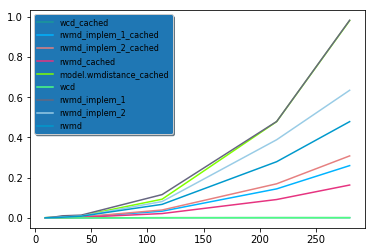

In [767]:
x = data[0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.plot(x, data[i, :, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=str(fn_names[i]+'_cached'))
for i in range(data_no_cache.shape[0]):
    ax.plot(x, data_no_cache[i, :, 0] / 10, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i])

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large', prop={'size': 8})

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

[  4.   4.   5.   6.   9.  13.  15.  15.  15.  19.  25.  43.  54.  66.
  72.  97. 114. 140. 151. 215. 280.]
[4.45326598e-03 4.47896798e-03 6.22984199e-03 7.92674100e-03
 1.45786240e-02 2.00635990e-02 2.32697650e-02 2.46381810e-02
 2.83733110e-02 4.36906330e-02 9.66671710e-02 2.47810379e-01
 3.33652562e-01 1.70784768e-01 3.99268190e-01 1.57374285e+00
 1.69564142e+00 3.11310565e+00 4.10620599e-01 7.67475893e+00
 1.48534201e+01]


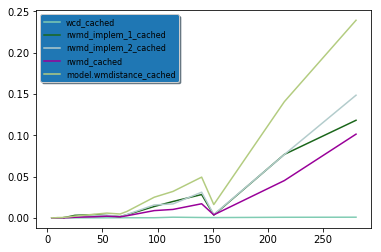

In [1336]:
x = data[0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)
print(x[x_args])
print(data[2, x_args, 0])

fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.plot(x[x_args], data[i, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=str(fn_names[i]+'_cached'))

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large', prop={'size': 8})

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

## Multiple documents

In [ ]:
def wmd_prefetch_prune_test(k, m):
    return [wmd_prefetch_prune(idx, [i for i in range(len(strs_proc))], k, m) for idx in range(len(strs_proc))]

In [ ]:
def wmdistance_test():
    a = np.array([i for i in range(len(strs_proc))])
    wmd_k_first = [[model.wmdistance(strs_proc[idx], strs_proc[j]) for j in a] for idx in range(len(strs_proc))]
    return a[np.argsort(wmd_k_first)][:, :7]

In [ ]:
def time_func_mul_docs(fn=rwmd, nb_docs=10, nb_iter=10):
    timing_data = np.zeros((nb_docs - 1, 2))
    for i in range(nb_docs - 1):
        if fn == model.wmdistance:
            def f():
                model.wmdistance(strs_proc[i], strs_proc[i + 1])
        else:
            def f():
                fn(i, i + 1)
        #timing_data[i][0] = timeit.timeit(f, number=nb_iter)
        timing_data[i][0] = timeit.Timer(f, 'gc.enable()').timeit(number=nb_iter)
        timing_data[i][1] = len(strs_proc[i]) + len(strs_proc[i + 1])
    
    return timing_data

In [ ]:
acc_score = 0
for d1, d2 in zip(wmd_nn, wmd_k_first):
    d1 = np.array(d1)
    index = np.in1d(d2, d1)
    score = np.sum(index == True) / len(d1)
    print(score)
    acc_score += score
print("Final score:", acc_score / len(wmd_nn))

In [ ]:
funcs = []
data = np.array([time_func(i, len(strs_proc), 100) for i in funcs])